# Setup

In [1]:
%load_ext autoreload
%autoreload 2
%aimport

Modules to reload:
all-except-skipped

Modules to skip:



In [2]:
from sparse_field_lib import load_data

In [3]:
import matplotlib.pyplot as plt
import torch

from bliss.datasets import sdss
from bliss.models import encoder, decoder
from bliss import sleep

from astropy.table import Table
from astropy.io import fits

In [4]:
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

import plotly.express as px
import plotly.graph_objects as go

In [5]:
# where is the sdss data? 
sdss_dir = '/home/imendoza/bliss/data/sdss/'

In [6]:
# check GPU is configured correctly
device = torch.device('cuda:0')
!echo $CUDA_VISIBLE_DEVICES

5


## Utility

In [7]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


def imshow_cbar(fig, ax, image, vmin=None, vmax=None, s=20): 
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    im = ax.imshow(image, vmin=vmin, vmax=vmax)
    cbar = fig.colorbar(im, cax=cax, orientation="vertical")
    cbar.ax.tick_params(labelsize=s)

# Load data

In [12]:
# get sdss data from frame to analyze
sdss_data = sdss.SloanDigitalSkySurvey(
    sdss_dir='../../data/sdss/',
    run=94,
    camcol=1,
    fields=(12,),
    bands=(2,),
    overwrite_cache=True,
    overwrite_fits_cache=True,
)

wcs = sdss_data[0]['wcs'][0]
frame = torch.tensor(sdss_data[0]['image'])[0].numpy()
frame_fits = Table(sdss_data[0]['po_fits'])
coadd_cat = Table.read('../../data/coadd_catalog_94_1_12.fits')
print(frame.shape)
print("# objects detected by photo on frame: ", len(frame_fits))
print("# objects detected by photo on coadd: ", len(coadd_cat))

(1489, 2048)
# objects detected by photo on frame:  999
# objects detected by photo on coadd:  901


In [9]:
fits_file = fitsio.FITS(catalog_file)[1]
wcs = sdss_data[0]['wcs'][0]
frame = torch.tensor(sdss_data[0]['image'])
coadd_cat = Table(fits_file[:])
frame, fits_file, wcs_list, sdss_data = load_data(sdss_dir=sdss_dir)

frame = frame[0].numpy()
print(frame.shape)

# objects detected by photo on frame:  999
# objects detected by photo on coadd:  901
(1489, 2048)


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Changed DATE-OBS from '19/09/98' to '1998-09-19''. [astropy.wcs.wcs]


In [10]:
wcs = wcs_list[0]
pt, pr = wcs.all_world2pix(fits_file['ra'][:], fits_file['dec'][:], 0)
pt_frame, pr_frame = wcs.all_world2pix(frame_fits['RA'].reshape(-1), frame_fits['DEC'].reshape(-1), 0)

# remove all locations that are not inside the image. 
keep = (pt > 0) & (pt < frame.shape[1]-1) & (pr > 0) & (pr < frame.shape[0]-1)
pt = pt[keep]
pr = pr[keep]
is_star = fits_file['probpsf'][:].astype(bool)[keep]


keep_frame = (pt_frame > 1) & (pt_frame < frame.shape[1]-1) & (pr_frame > 1) & (pr_frame < frame.shape[0]-1)
pt_frame = pt_frame[keep_frame]
pr_frame = pr_frame[keep_frame]
is_star_frame = (frame_fits['OBJC_TYPE'][:]==6).astype(bool)[keep_frame]

# Visualize Frame

(1489, 2048)


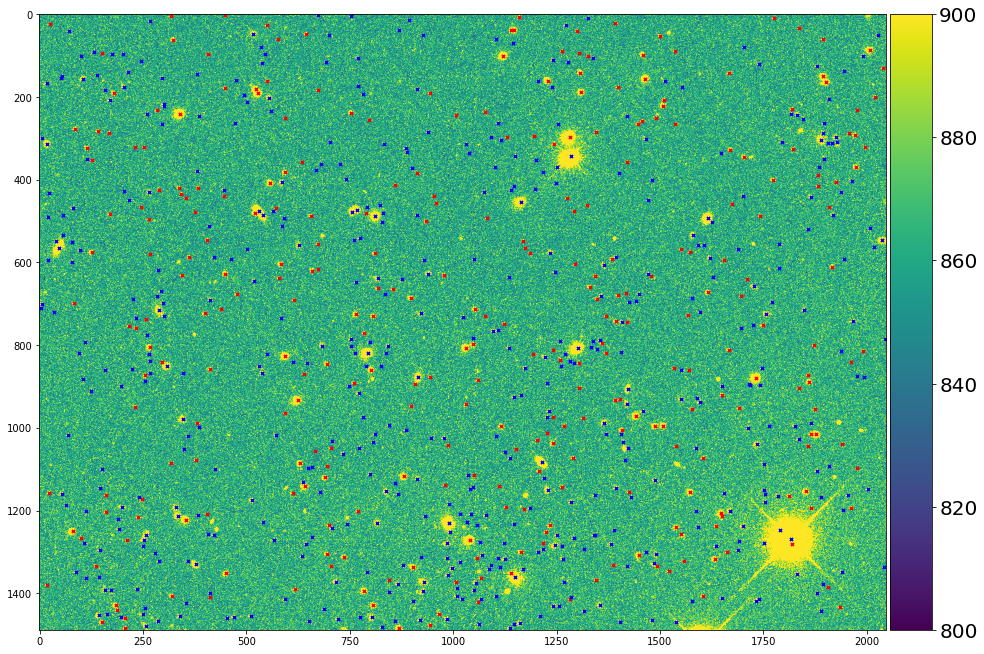

In [11]:
%matplotlib inline
print(frame.shape)
fig, ax = plt.subplots(1, 1, figsize=(16, 12))
imshow_cbar(fig, ax, frame, vmin=800, vmax=900)
ax.scatter(x=pt[is_star], y=pr[is_star], c='r', marker='x', s=10)
ax.scatter(x=pt[~is_star], y=pr[~is_star], c='b', marker='x', s=10)

In [14]:
# # plotly
# fig = px.imshow(frame, zmin=800, zmax=900)
# scatter_galaxies_true = go.Scatter(name='true_galaxy', x=pt[~is_star], y=pr[~is_star], mode='markers', marker=dict(color='blue', size=7, symbol='x'))
# scatter_stars_true = go.Scatter(name='true_star', x=pt[is_star], y=pr[is_star], mode='markers', marker=dict(color='red', size=7, symbol='x'))

# fig.add_trace(scatter_galaxies_true)
# fig.add_trace(scatter_stars_true)

# Run BLISS on 300x300 chunk

## prepare model

In [15]:
from bliss.models.galaxy_encoder import GalaxyEncoder
from bliss.models.binary import BinaryEncoder
from bliss.predict import prediction

In [16]:
# prepare BLISS model 
sleep_file = '/home/imendoza/bliss/models/sdss_sleep.ckpt'
galaxy_encoder_file = '/home/imendoza/bliss/models/sdss_galaxy_encoder.ckpt'
binary_file = '/home/imendoza/bliss/models/sdss_binary.ckpt'

sleep_net = sleep.SleepPhase.load_from_checkpoint(sleep_file)
image_decoder = sleep_net.image_decoder.to(device).eval()
image_encoder= sleep_net.image_encoder.to(device).eval()
galaxy_encoder = GalaxyEncoder.load_from_checkpoint(galaxy_encoder_file).to(device).eval()
binary_encoder = BinaryEncoder.load_from_checkpoint(binary_file).to(device).eval()

## choose chunk

In [32]:
lims = [
    ((450, 750), (350, 650)), #fiducial
    ((1250, 1550), (680, 980)), #random
    ((200, 500), (1050, 1350)), #blends
    ((1000, 1300), (1150, 1450)), #blends -> paper, full scene # 2
    ((1700, 2000), (100, 400)), #blends
    ((600, 900), (400, 700)), #galaxy blends (1) -> paper, blend # 1
    ((1700, 2000), (200, 500)), #galaxy blends (2)
    ((800, 1100), (1150, 1450)), #galaxy blends (3)
    ((50, 350), (1150, 1450)), #galaxy blends (4)
    ((200, 500), (600, 900)), #galaxy blends (5) -> paper, blend # 2
    ((1100, 1400), ((950, 1250))), #another large galaxy
    ((1000, 1300), (50, 350)), # very faint, small sources. 
    ((900, 1200), (1100, 1400)), # random
    ((1500, 1800), (400, 700)),
    ((1700, 2000), (200, 500)), # galaxy blend -> paper, full scene # 1
]    
choice = 3
xlim, ylim = lims[choice]

In [33]:
assert xlim[1] - xlim[0] == 300 
assert ylim[1] - ylim[0] == 300
bp = image_encoder.border_padding

chunk = frame[ylim[0]-bp:ylim[1]+bp, xlim[0]-bp:xlim[1]+bp]

# restrict to 300x300 chunk 
keep = (pt > xlim[0]) & (pt < xlim[1]) & (pr < ylim[1]) & (pr > ylim[0])
keep_frame = (pt_frame > xlim[0]) & (pt_frame < xlim[1]) & (pr_frame < ylim[1]) & (pr_frame > ylim[0])

# obtain star and galaxy bools for each location.
galaxy_bool = (~is_star) & keep
star_bool = is_star & keep
galaxy_bool_frame = (~is_star_frame) & keep_frame
star_bool_frame = (is_star_frame) & keep_frame

#account for bias
_pt = pt - (xlim[0] - bp)
_pr = pr - (ylim[0] - bp)

_pt_frame = pt_frame - (xlim[0] - bp)
_pr_frame = pr_frame - (ylim[0] - bp)

# move image to device
slen = 300 + 2 * bp
chunk = torch.from_numpy(chunk.reshape(1, 1, *chunk.shape)[:, :, :slen, :slen]).to(device)

# for plotting
_chunk = chunk.reshape(slen,slen).cpu().numpy()
print(chunk.shape, _chunk.shape)

torch.Size([1, 1, 348, 348]) (348, 348)


## get estimate from chunk

In [34]:
with torch.no_grad():

    _, tile_est, est_params = prediction(chunk, image_encoder, galaxy_encoder, binary_encoder)

    # plot image from tile est.
    recon_image, _ = image_decoder.render_images(
        tile_est["n_sources"],
        tile_est["locs"],
        tile_est["galaxy_bool"],
        tile_est["galaxy_params"],
        tile_est["fluxes"],
        add_noise=False,
    )
    
    _slen = chunk.shape[-1] - image_encoder.border_padding*2

## plot detections

In [35]:
import plotly.express as px
import plotly.graph_objects as go
p_box = widgets.Dropdown(options=[1e-6, 5e-6, 1e-5, 5e-5, 1e-4, 5e-4, 1e-3,5e-3,1e-2,5e-2, 0.1, 0.3], description="p1")
@interact(p=p_box)
def plot_chunk(p):
    vmin = np.quantile(_chunk.flatten(), p)
    vmax = np.quantile(_chunk.flatten(), 1.-p)
    fig = px.imshow(_chunk, zmin=vmin, zmax=vmax)

    # scatter objects.
    scatter_galaxies_frame = go.Scatter(name='frame_galaxy', x=_pt_frame[galaxy_bool_frame], y=_pr_frame[galaxy_bool_frame], mode='markers', marker=dict(color='green', size=8, symbol='x'))
    scatter_stars_frame = go.Scatter(name='frame_star', x=_pt_frame[star_bool_frame], y=_pr_frame[star_bool_frame], mode='markers', marker=dict(color='purple', size=8, symbol='x'))

    scatter_galaxies_true = go.Scatter(name='true_galaxy', x=_pt[galaxy_bool], y=_pr[galaxy_bool], mode='markers', marker=dict(color='red', size=8, symbol='x'))
    scatter_stars_true = go.Scatter(name='true_star', x=_pt[star_bool], y=_pr[star_bool], mode='markers', marker=dict(color='orange', size=8, symbol='x'))

    _locs = est_params['locs']*_slen + image_encoder.border_padding - 0.5
    _locs = _locs.detach().cpu().numpy()[0]
    _galaxy_bool = est_params['galaxy_bool'].bool().detach().cpu().numpy()[0, :, 0]
    _prob_galaxy = est_params['prob_galaxy'].float().detach().cpu().numpy()[0, :, 0]
    _prob_n_sources = est_params['prob_n_sources'].float().detach().cpu().numpy()[0, :, 1]


    scatter_galaxies_est = go.Scatter(name='est_galaxy', x=_locs[:, 1][_galaxy_bool], y=_locs[:, 0][_galaxy_bool], 
                                      mode='markers', marker=dict(color='blue', size=8, symbol='cross'),
                                      hovertext=[f'prob_galaxy:{x:.2f}; prob_one_source: {y:.2f}' for (x,y) 
                                                 in zip(_prob_galaxy[_galaxy_bool], _prob_n_sources[_galaxy_bool])]
                                     )
    scatter_stars_est = go.Scatter(name='est_star', x=_locs[:, 1][~_galaxy_bool], y=_locs[:, 0][~_galaxy_bool], 
                                   mode='markers', marker=dict(color='cyan', size=8, symbol='cross'),
                                  hovertext=[f'prob_galaxy:{x:.2f}; prob_one_source: {y:.2f}' for (x,y) in 
                                             zip(_prob_galaxy[~_galaxy_bool], _prob_n_sources[~_galaxy_bool])]
                                  )

    # add traces
    fig.update_layout(width=800, height=800)
    fig.add_trace(scatter_galaxies_true)
    fig.add_trace(scatter_stars_true)
    fig.add_trace(scatter_galaxies_est)
    fig.add_trace(scatter_stars_est)
    fig.add_trace(scatter_galaxies_frame)
    fig.add_trace(scatter_stars_frame)
    fig.update_layout(legend=dict(orientation="h", y=1.02))
    
    # add border padding
    fig.add_shape(type="line", x0=24, x1=24, y0=0, y1=348, line=dict(color='white', width=3))
    fig.add_shape(type="line", x0=324, x1=324, y0=0, y1=348, line=dict(color='white', width=3))
    fig.add_shape(type="line", x0=0, x1=348, y0=24, y1=24, line=dict(color='white', width=3))
    fig.add_shape(type="line", x0=0, x1=348, y0=324, y1=324, line=dict(color='white', width=3))


    fig.show()


interactive(children=(Dropdown(description='p1', options=(1e-06, 5e-06, 1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0…

In [36]:
from plot_defaults import set_rc_params

In [37]:
%matplotlib inline
p1_box = widgets.Dropdown(options=[1e-6, 5e-4, 1e-3,5e-3,1e-2,5e-2, 0.1, 0.3], description="p1")
p2_box = widgets.Dropdown(options=[1e-6, 1e-4, 5e-4, 1e-3,5e-3,1e-2,5e-2, 0.1, 0.3], description="p2")
fontsize_box = widgets.Dropdown(options=[8, 10, 12, 14, 16, 18, 20], description="fontsize")
markersize_box = widgets.Dropdown(options=[2, 4, 6, 8, 10, 12], description="fontsize")
@interact(p1=p1_box, p2=p2_box, fontsize = fontsize_box, markersize=markersize_box)
def plot_residuals(p1, p2, fontsize):
    
    # default
    xrange = (0, 300)
    yrange = (0, 300)
    
#     blend (1)
#     xrange = (135, 185)
#     yrange = (50, 100)

# #     blend (2)
#     xrange = (180, 230)
#     yrange = (90, 140)
    
    set_rc_params(figsize=(21, 7), lines_marker_size=8)
    
    
    fig, axes = plt.subplots(1, 3)
    _recon_image = recon_image.detach().cpu().numpy()[0, 0]


    # crop the border padding since it will dominate reconstruction.
    bp = image_encoder.border_padding
    __chunk = _chunk[bp+yrange[0]:slen-bp-(_slen-yrange[1]), bp+xrange[0]:slen-bp-(_slen-xrange[1])]
    __recon_image = _recon_image[bp+yrange[0]:slen-bp-(_slen-yrange[1]), bp+xrange[0]:slen-bp-(_slen-xrange[1])]
    residual = (__chunk - __recon_image)/np.sqrt(__recon_image)
    
    ax1, ax2, ax3 = axes


    combined = np.hstack([__chunk.flatten(), __recon_image.flatten()])
    vmin1 = np.quantile(combined, p1)
    vmax1 = np.quantile(combined, 1. - p1)
    vmin2 = np.quantile(residual.flatten(), p2)
    vmax2 = np.quantile(residual.flatten(), 1. - p2)

    # plot the chunk and reconstruction image side by side.
    im1 = imshow_cbar(fig, ax1, __chunk, vmin=vmin1, vmax=vmax1)
    im2 = imshow_cbar(fig, ax2, __recon_image, vmin=vmin1, vmax=vmax1)
    im3 = imshow_cbar(fig, ax3, residual, vmin=vmin2, vmax=vmax2)

    # true image and true locations
    __pt = _pt - bp - xrange[0]
    __pr = _pr - bp - yrange[0]
    keep = (__pt > 0) & (__pr > 0) & (__pt < xrange[1] - xrange[0]) & (__pr < yrange[1] - yrange[0])
    __pt = __pt[keep]
    __pr = __pr[keep]
    galaxy_bool_ = galaxy_bool[keep]
    star_bool_ = star_bool[keep]
    ax1.scatter(__pt[galaxy_bool_], __pr[galaxy_bool_], marker='x', color='r')
    ax1.scatter(__pt[star_bool_], __pr[star_bool_], marker='+', color='b')
    

    # overlay the map estimate params on the full image
    _locs = est_params['locs']*_slen - 0.5
    _locs = _locs.detach().cpu().numpy()[0]
    _galaxy_bool = est_params['galaxy_bool'].bool().detach().cpu().numpy()[0, :, 0]
    _prob_galaxy = est_params['prob_galaxy'].float().detach().cpu().numpy()[0, :, 0]
    
    # need to adjust _locs also based on ranges
    # note it already accounts for border padding.
    _locs[:, 1] = _locs[:, 1] - xrange[0]
    _locs[:, 0] = _locs[:, 0] - yrange[0]
    
    # TODO: filter and get keep... 
    keep_est = (_locs[:, 0] > 0) & (_locs[:, 1] > 0) & (_locs[:, 1] < xrange[1] - xrange[0]) & (_locs[:, 0] < yrange[1] - yrange[0])
    
    _locs = _locs[keep_est]
    _galaxy_bool = _galaxy_bool[keep_est]
    _prob_galaxy = _prob_galaxy[keep_est]


    
    ax2.scatter(_locs[:, 1][_galaxy_bool], _locs[:, 0][_galaxy_bool], marker='x', color='r')
    ax2.scatter(_locs[:, 1][~_galaxy_bool], _locs[:, 0][~_galaxy_bool], marker='+', color='b')

    # annotate with probabilities for sharing
    for prob, (yi, xi) in zip(_prob_galaxy[_galaxy_bool], _locs[_galaxy_bool]):
        ax2.annotate(f"{prob:.2f}", (xi, yi), color='r', fontsize=fontsize)

    for prob, (yi, xi) in zip(_prob_galaxy[~_galaxy_bool], _locs[~_galaxy_bool]):
        ax2.annotate(f"{prob:.2f}", (xi, yi), color='b', fontsize=fontsize)



    print('red = galaxy')
    print('blue = star')

    ax1.tick_params(labelsize=18, length=3, width=2)
    ax2.tick_params(labelsize=18, length=3, width=2)
    plt.tight_layout()


    plt.show()

interactive(children=(Dropdown(description='p1', options=(1e-06, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.3), …